In [1]:
##### ETL NOTEBOOK FOR 2023 MHSAA TOURNEY SPECIFIC MAP

#### Adapted from ETL for JSON

## Dependencies and Setup
### Dependencies

from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import os
import re
import time

## Start timer
start_time = time.time()


In [2]:
## LOAD BLOCK###
#### Load data from kml file exported from Google Earth

file_path = ('data/kml/MHSAA_2023.kml') # file path to kml file


# Read the KML file
with open(file_path) as file:
    xml_data = file.read()

# Initialize soup variables for parsing file
soup = BeautifulSoup(xml_data, 'xml')
folders = soup.Document.Folder
list = soup.Document.Folder.find_all('Folder')

# Create a list to store rows to append to the DataFrame
rows = []

# Loop through the folders and extract the data
for folder in list:
    try:
        field_name = folder.find('name').text
        foul = folder.find_all('coordinates')[0].text
        fop = folder.find_all('coordinates')[1].text
        notes = None

        # Check if there is a description tag, if so, use it for notes
        if folder.find('description') is not None:
            notes = folder.find('description').text

        row = {
            'field': field_name,
            'foul': foul,
            'fop': fop,
            'notes': notes
        }

        rows.append(row)

    except Exception as e:
        # Add name of folder to a list of failed folders
        failed.append(folder.find('name').text)
        print(f"Error processing folder: {folder.find('name').text}. Error message: {str(e)}")

# Convert the list of rows to a DataFrame
df = pd.DataFrame(rows, columns=['field', 'foul', 'fop', 'notes'])

# print('Failed to parse:', failed)


In [3]:
df.head()

,field,foul,fop,notes
0,Muskegon Western Michigan Christian HS,"\n\t\t\t\t\t\t\t\t-86.23679559999999,43.160902...","\n\t\t\t\t\t\t\t\t-86.23679559999999,43.160902...",None
1,St Joseph HS,"\n\t\t\t\t\t\t\t\t-86.4923405,42.0912197,0 -86...","\n\t\t\t\t\t\t\t\t-86.4923405,42.0912197,0 -86...",no fence in foul outfield
2,Petoskey High School,"\n\t\t\t\t\t\t\t\t-84.93868740000001,45.367230...","\n\t\t\t\t\t\t\t\t-84.93868740000001,45.367230...",None
3,U of M - college,"\n\t\t\t\t\t\t\t\t-83.7420742,42.2678568,0 -83...","\n\t\t\t\t\t\t\t\t-83.7420742,42.2678568,0 -83...",None
4,Sagniaw Valley State - college,"\n\t\t\t\t\t\t\t\t-83.95339989999999,43.512229...","\n\t\t\t\t\t\t\t\t-83.95339989999999,43.512229...",None


In [4]:
# Clean the new dataframe


# Create a copy of the original DataFrame
df_cleaned = df.copy()

# Remove new line and space characters from coordinates
df_cleaned = df_cleaned.replace(r'\n','', regex=True) 
df_cleaned = df_cleaned.replace(r'\t','', regex=True) 

# Drop any duplicate rows
df_cleaned = df_cleaned.drop_duplicates(subset=['field'], keep='first')

# Drop any rows with empty fields
df_cleaned = df_cleaned[(df_cleaned != 0).all(1)]

In [5]:
df_cleaned.info()
df_cleaned.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127 entries, 0 to 130
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   field   127 non-null    object
 1   foul    127 non-null    object
 2   fop     127 non-null    object
 3   notes   4 non-null      object
dtypes: object(4)
memory usage: 5.0+ KB


,field,foul,fop,notes
0,Muskegon Western Michigan Christian HS,"-86.23679559999999,43.1609022,0 -86.236754,43....","-86.23679559999999,43.1609022,0 -86.2356235,43...",None
1,St Joseph HS,"-86.4923405,42.0912197,0 -86.4923378,42.092111...","-86.4923405,42.0912197,0 -86.4911402,42.091221...",no fence in foul outfield
2,Petoskey High School,"-84.93868740000001,45.36723030000001,0 -84.938...","-84.93868740000001,45.36723030000001,0 -84.937...",None
3,U of M - college,"-83.7420742,42.2678568,0 -83.74204469999999,42...","-83.7420742,42.2678568,0 -83.74325570000001,42...",None
4,Sagniaw Valley State - college,"-83.95339989999999,43.5122297,0 -83.9533737,43...","-83.95339989999999,43.5122297,0 -83.9521446,43...",None


In [6]:
##### Clean up polygon data and create a new home_plate column

def parse_coordinates(coord_string):
    coords = coord_string.split()
    parsed_coords = [tuple(map(float, coord.split(',')[:2])) for coord in coords]
    return parsed_coords

# Create a new column for the home_plate location using the first set of coordinates in the 'fop' column
df_cleaned['home_plate'] = df_cleaned['fop'].apply(lambda x: parse_coordinates(x)[0])

# Apply the parse_coordinates function to the 'foul' and 'fop' columns
df_cleaned['foul'] = df_cleaned['foul'].apply(parse_coordinates)
df_cleaned['fop'] = df_cleaned['fop'].apply(parse_coordinates)


In [7]:
############## AREA CALCULATION ##############


import pyproj
from shapely.geometry import Polygon
from shapely.ops import transform


def calculate_area(coords):
    # Create a Polygon object from the coordinates
    polygon = Polygon(coords)

    # Calculate the centroid of the polygon
    centroid = polygon.centroid

    # Create a custom LAEA projection centered on the centroid
    custom_projection = f"+proj=laea +lat_0={centroid.y} +lon_0={centroid.x} +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"

    # Create a transformer for converting coordinates to the custom LAEA projection
    transformer = pyproj.Transformer.from_crs(
        pyproj.CRS("EPSG:4326"),  # WGS 84 (latitude and longitude)
        pyproj.CRS(custom_projection),  # Custom LAEA projection
        always_xy=True
    )

    # Define a function to transform coordinates using the transformer
    def transform_coordinates(x, y):
        return transformer.transform(x, y)

    # Convert the coordinates to the custom LAEA projection
    polygon_laea = transform(transform_coordinates, polygon)

    # Calculate the area in square meters
    area_sqm = polygon_laea.area

    # Convert the area to square feet (1 square meter = 10.764 square feet)
    area_sqft = area_sqm * 10.764

    return area_sqft



### Call Function and add to dataframe
df_cleaned['foul_area_sqft'] = df_cleaned['foul'].apply(calculate_area)
df_cleaned['fop_area_sqft'] = df_cleaned['fop'].apply(calculate_area)

## Calculate the total area of the field and the ratio of foul area to field area
df_cleaned['field_area_sqft'] = df_cleaned['foul_area_sqft'] + df_cleaned['fop_area_sqft']
## Percentage foul area
df_cleaned['foul_area_per'] = df_cleaned['foul_area_sqft'] / df_cleaned['field_area_sqft']
## Fair to Foul Ratio
df_cleaned['fair_to_foul'] = df_cleaned['fop_area_sqft'] / df_cleaned['foul_area_sqft']


In [8]:
############# FENCE DISTANCE CALCULATION #############

from geopy.distance import great_circle
import numpy as np

def interpolate_points(start, end, length_ratio):
    start_np = np.array(start)
    end_np = np.array(end)
    return tuple(start_np + (end_np - start_np) * length_ratio)

def calculate_distances(home_plate, outfield_coords, num_points=90):
    def is_same_point(point1, point2, tolerance=1e-6):
        return abs(point1[0] - point2[0]) < tolerance and abs(point1[1] - point2[1]) < tolerance

    home_plate_lat_lon = (home_plate[1], home_plate[0])
    distances = []

    # Calculate total line length
    total_length = 0
    segments = []
    for i in range(len(outfield_coords) - 1):
        start = outfield_coords[i]
        end = outfield_coords[i + 1]
        if not is_same_point(home_plate, start) and not is_same_point(home_plate, end):
            segment_length = great_circle((start[1], start[0]), (end[1], end[0])).feet
            segments.append((start, end, segment_length))
            total_length += segment_length

    # Calculate the distance between equally spaced points
    spacing = total_length / (num_points - 1)

    # Interpolate points and calculate distances
    current_length = 0
    segment_index = 0
    for i in range(num_points):
        while segment_index < len(segments) - 1 and current_length > segments[segment_index][2]:
            current_length -= segments[segment_index][2]
            segment_index += 1

        start, end, segment_length = segments[segment_index]
        length_ratio = current_length / segment_length
        point = interpolate_points(start, end, length_ratio)
        distance = round(great_circle(home_plate_lat_lon, (point[1], point[0])).feet)
        distances.append(distance)

        current_length += spacing

    return distances

# Calculate distances for each row
df_cleaned['distances'] = df_cleaned.apply(lambda row: calculate_distances(row['home_plate'], row['fop']), axis=1)

# Calculate max, min, and average distances for each row
df_cleaned['max_distance'] = df_cleaned['distances'].apply(max)
df_cleaned['min_distance'] = df_cleaned['distances'].apply(min)
df_cleaned['avg_distance'] = df_cleaned['distances'].apply(lambda distances: sum(distances) / len(distances))
# get the median distance
df_cleaned['median_distance'] = df_cleaned['distances'].apply(lambda distances: np.median(distances))


In [9]:
######## CHECK BLOCK ########

## Check how long the distance list is for each row
df_cleaned['num_distances'] = df_cleaned['distances'].apply(len)

## Print the value counts for the 'num_distances' column
df_cleaned['num_distances'].value_counts()

90    127
Name: num_distances, dtype: int64

In [10]:
########## NOT NECESSARY FOR THIS PROJECT ##########

# ### Get Geolocation of each field based on home plate coordinates and return state and country
# ### This block takes a long time to run - will need to revisit
# ## up to ten minutes

# from geopy.geocoders import Nominatim
# from geopy.exc import GeocoderTimedOut, GeocoderServiceError
# from tqdm import tqdm

# geolocator = Nominatim(user_agent="baseball_field_locator")

# # Function to get location information
# def get_location_info(lng, lat):
#     try:
#         location = geolocator.reverse((lat, lng), timeout=10)
#         state = location.raw['address'].get('state', None)
#         country = location.raw['address'].get('country', None)
#         return state, country
#     except GeocoderTimedOut:
#         print(f"GeocoderTimedOut error for coordinates: ({lng}, {lat})")
#         return None, None
#     except GeocoderServiceError:
#         print(f"GeocoderServiceError for coordinates: ({lng}, {lat})")
#         return None, None

# # Extract the first coordinate for each field
# df_cleaned['lng'], df_cleaned['lat'] = zip(*df_cleaned['home_plate'].apply(lambda x: x))

# # Wrap the DataFrame apply function with tqdm for progress indication
# tqdm.pandas(desc="Processing coordinates")

# # Get state and country information for each field
# df_cleaned[['state', 'country']] = df_cleaned.progress_apply(lambda row: get_location_info(row['lng'], row['lat']), axis=1, result_type='expand')


In [11]:
## Function to create ranks for each column

def rank_fields(df):
    # Calculate the rank for each category
    df['max_distance_rank'] = df['max_distance'].rank(ascending=False, method='min')
    df['min_distance_rank'] = df['min_distance'].rank(ascending=False, method='min')
    df['avg_distance_rank'] = df['avg_distance'].rank(ascending=False, method='min')
    df['median_distance_rank'] = df['median_distance'].rank(ascending=False, method='min')
    df['field_area_rank'] = df['field_area_sqft'].rank(ascending=False, method='min')
    df['foul_area_rank'] = df['foul_area_sqft'].rank(ascending=False, method='min')
    df['fop_area_per_rank'] = df['fop_area_sqft'].rank(ascending=False, method='min')
    df['ratio_rank'] = df['fair_to_foul'].rank(ascending=False, method='min')

    return df



In [12]:
## Run Function

df_cleaned = rank_fields(df_cleaned)

In [13]:
#### Orienting the map to the home plate location ####

### Find the center of the field
def calculate_centroid(coords):
    x_coords = [coord[0] for coord in coords]
    y_coords = [coord[1] for coord in coords]
    centroid_x = sum(x_coords) / len(coords)
    centroid_y = sum(y_coords) / len(coords)
    return (centroid_x, centroid_y)


## Find the bearing between the home plate and the center of the field
import math

def calculate_bearing(point1, point2):
    lat1, lon1 = math.radians(point1[1]), math.radians(point1[0])
    lat2, lon2 = math.radians(point2[1]), math.radians(point2[0])

    d_lon = lon2 - lon1

    x = math.cos(lat2) * math.sin(d_lon)
    y = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(d_lon)

    bearing = math.degrees(math.atan2(x, y))
    bearing = (bearing + 360) % 360  # Normalize the bearing to the range [0, 360)

    return bearing

### Function to classify direction in laymans terms North, South, East, West, ect
def degrees_to_cardinal_direction(degrees):
    directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N']
    index = round(degrees / 45)
    return directions[index]


In [14]:
# Calculate the centroid of the outfield fence coordinates for each row
df_cleaned['fop_centroid'] = df_cleaned['fop'].apply(lambda coords: calculate_centroid(coords[1:]))

# Calculate the bearing between home plate and the centroid for each row
df_cleaned['field_orientation'] = df_cleaned.apply(lambda row: calculate_bearing(row['home_plate'], row['fop_centroid']), axis=1)

# Convert the bearing to a cardinal direction
df_cleaned['field_cardinal_direction'] = df_cleaned['field_orientation'].apply(degrees_to_cardinal_direction)



### All the geo transformation should take place above this

## starting the process of matching in data from other sources

In [15]:
######### RENAME field to park_name #########
###### SHould move up the file ######

df_cleaned.rename(columns={'field': 'park_name'}, inplace=True)

In [16]:
######### NEED TO RENAME TO WORK WITH NEXT BLOCK #########

df_cleaned.info()

df_cleaned.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127 entries, 0 to 130
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   park_name                 127 non-null    object 
 1   foul                      127 non-null    object 
 2   fop                       127 non-null    object 
 3   notes                     4 non-null      object 
 4   home_plate                127 non-null    object 
 5   foul_area_sqft            127 non-null    float64
 6   fop_area_sqft             127 non-null    float64
 7   field_area_sqft           127 non-null    float64
 8   foul_area_per             127 non-null    float64
 9   fair_to_foul              127 non-null    float64
 10  distances                 127 non-null    object 
 11  max_distance              127 non-null    int64  
 12  min_distance              127 non-null    int64  
 13  avg_distance              127 non-null    float64
 14  median_dis

,park_name,foul,fop,notes,home_plate,foul_area_sqft,fop_area_sqft,field_area_sqft,foul_area_per,fair_to_foul,...,min_distance_rank,avg_distance_rank,median_distance_rank,field_area_rank,foul_area_rank,fop_area_per_rank,ratio_rank,fop_centroid,field_orientation,field_cardinal_direction
0,Muskegon Western Michigan Christian HS,"[(-86.2367956, 43.1609022), (-86.236754, 43.16...","[(-86.2367956, 43.1609022), (-86.2356235, 43.1...",None,"(-86.2367956, 43.1609022)",28662.155920,91282.061102,119944.217022,0.238962,3.184759,...,90.0,38.0,46.0,53.0,56.0,52.0,74.0,"(-86.23598504615383, 43.161468603846146)",46.228958,NE
1,St Joseph HS,"[(-86.4923405, 42.0912197), (-86.4923378, 42.0...","[(-86.4923405, 42.0912197), (-86.4911402, 42.0...",no fence in foul outfield,"(-86.4923405, 42.0912197)",40944.376484,95222.837921,136167.214406,0.300692,2.325663,...,16.0,27.0,25.0,10.0,4.0,26.0,123.0,"(-86.49156794375001, 42.091818531250006)",43.751664,NE
2,Petoskey High School,"[(-84.9386874, 45.36723030000001), (-84.938694...","[(-84.9386874, 45.36723030000001), (-84.937461...",None,"(-84.9386874, 45.36723030000001)",30317.378481,91940.911472,122258.289954,0.247978,3.032614,...,42.0,51.0,42.0,41.0,43.0,43.0,77.0,"(-84.937801, 45.36784928)",45.173452,NE
3,U of M - college,"[(-83.7420742, 42.2678568), (-83.7420447, 42.2...","[(-83.7420742, 42.2678568), (-83.7432557, 42.2...",None,"(-83.7420742, 42.2678568)",19408.615773,100786.703042,120195.318816,0.161476,5.192885,...,62.0,15.0,9.0,51.0,117.0,13.0,2.0,"(-83.74269802222221, 42.26723842222222)",216.742562,SW
4,Sagniaw Valley State - college,"[(-83.9533999, 43.5122297), (-83.9533737, 43.5...","[(-83.9533999, 43.5122297), (-83.9521446, 43.5...",None,"(-83.9533999, 43.5122297)",39784.867681,106233.673037,146018.540718,0.272464,2.670203,...,4.0,6.0,6.0,4.0,9.0,6.0,105.0,"(-83.95257657254905, 43.512889217647064)",42.155934,NE


In [17]:


# ### Save the cleaned DataFrame to a prelim json

# df_cleaned.to_json('data/mhsaa_step1.json', orient='records')

In [18]:
parks_df = df_cleaned.copy()

## WORKING HERE DOWN

In [19]:
import json
import pandas as pd
import numpy as np

### Load the host team info with nickname and team colors
path = 'data/2023_district_hosts.csv'
host_df = pd.read_csv(path)

# ## Load the prelim json
# path = 'data/mhsaa_step1.json'
# with open(path) as f:
#     data = json.load(f)
# parks_df = pd.DataFrame(data)

## open messy table to pull the notes column
## merge based on the district number 
path = 'data\district_notes.csv'
messe_df = pd.read_csv(path)

# Clean up note column
messe_df['Plot Note'] = messe_df['Plot Note'].replace('y', np.nan)

In [20]:
### DEBUG

host_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   team      127 non-null    object 
 1   division  127 non-null    int64  
 2   district  127 non-null    int64  
 3   host      127 non-null    object 
 4   nickname  127 non-null    object 
 5   color1    127 non-null    object 
 6   color2    127 non-null    object 
 7   color3    12 non-null     object 
 8   color4    0 non-null      float64
 9   score     127 non-null    int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 10.0+ KB


In [21]:
## Matching Function to compair host names to park names 

import pandas as pd
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

def find_host_matches(host_df, parks_df):
    # Initialize empty lists to store the matches and unmatched park names
    matches = []
    unmatched_park_names = []

    # Iterate over each host and district in the host_df
    for host, district in zip(host_df['host'], host_df['district']):
        # Use fuzzy matching to find potential matches in park names
        potential_matches = process.extractBests(host, parks_df['park_name'], scorer=fuzz.token_set_ratio, score_cutoff=80)

        # Store the host, district, and potential matches with their scores
        matches.append({'host': host, 'district': district, 'potential_matches': potential_matches})

        # Check if any strong matches were found
        if len(potential_matches) > 0:
            max_score = max(potential_matches, key=lambda x: x[1])[1]
            if max_score >= 80:
                continue

        # If no strong matches were found, add the park name to unmatched list
        unmatched_park_names.append((host, district))

    # Create a dataframe from the matches list
    matches_df = pd.DataFrame(matches)

    # Count the number of strong matches and unmatched park names
    strong_matches_count = matches_df['potential_matches'].apply(lambda x: sum(match[1] >= 80 for match in x)).sum()
    unmatched_count = len(unmatched_park_names)

    print("Number of strong matches:", strong_matches_count)
    print("Number of unmatched park names:", unmatched_count)
    print("Unmatched park names:", unmatched_park_names)

    return matches_df




In [22]:
# Call the function to find host matches
result_df = find_host_matches(host_df, parks_df)

# Merge the result_df to messe_df on district number
merged_df = result_df.merge(messe_df, left_on='district', right_on='district number')

# Select the desired columns
merged_df = merged_df[['host', 'district', 'potential_matches', 'Plot Note', 'Map Link MHSAA']]
merged_df.head()
# merged_df.info()

Number of strong matches: 118
Number of unmatched park names: 13
Unmatched park names: [('Allen Park', 18), ('Detroit Western', 19), ('St Clair Shores Lake Shore', 21), ('Detroit U of D Jesuit', 23), ('Bloomfield Hills Brother Rice', 24), ('Dearborn Divine Child', 53), ('Houghton Lake', 68), ('Detroit Communication Media Arts', 89), ('Detroit Osborn', 91), ('Painesdale Jeffers', 97), ('Brethren', 107), ('East Jackson', 118), ('Waterford Our Lady of the Lakes', 126)]


,host,district,potential_matches,Plot Note,Map Link MHSAA
0,Marquette,1,"[(Marquette HS - Hurley Field, 100, 130)]",NaN,http://maps.google.com/maps?q=North Marquette ...
1,Midland Dow,2,"[(Midland HH Dow High School, 100, 21)]",NaN,http://maps.google.com/maps?q=H H Dow High Sch...
2,Muskegon Mona Shores,3,"[(Muskegon Mona Shores HS, 100, 129)]",NaN,http://maps.google.com/maps?q=Mona Shores Base...
3,Grand Rapids Forest Hills Northern,4,"[(Grand Rapids Forest Hills Northern HS, 100, ...",NaN,http://maps.google.com/maps?q=FHN Stadium - Ba...
4,Grandville,5,"[(Grandville High School - high school, 100, 1...",NaN,http://maps.google.com/maps?q=Grandville High ...


In [23]:
### Keep only the field name from the potential matches, ignore if the potential match is empty
merged_df['potential_matches'] = merged_df['potential_matches'].apply(lambda x: x[0][0] if len(x) > 0 else np.nan)


# merged_df['potential_matches'] = merged_df['potential_matches'].apply(lambda x: x[0][0])

# Rename the potential_matches column to park_name

merged_df.rename(columns={'potential_matches': 'park_name'}, inplace=True)


merged_df.head()
merged_df.info()
# # Merge the merged_df to the parks_df on park_name

# parks_df = parks_df.merge(merged_df, on='park_name', how='left')



<class 'pandas.core.frame.DataFrame'>
Int64Index: 127 entries, 0 to 126
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   host            127 non-null    object
 1   district        127 non-null    int64 
 2   park_name       114 non-null    object
 3   Plot Note       11 non-null     object
 4   Map Link MHSAA  125 non-null    object
dtypes: int64(1), object(4)
memory usage: 6.0+ KB


In [24]:
## Merge the merged_df to the parks_df on park_name
parks_df = parks_df.merge(merged_df, on='park_name', how='left')

parks_df.head()


,park_name,foul,fop,notes,home_plate,foul_area_sqft,fop_area_sqft,field_area_sqft,foul_area_per,fair_to_foul,...,foul_area_rank,fop_area_per_rank,ratio_rank,fop_centroid,field_orientation,field_cardinal_direction,host,district,Plot Note,Map Link MHSAA
0,Muskegon Western Michigan Christian HS,"[(-86.2367956, 43.1609022), (-86.236754, 43.16...","[(-86.2367956, 43.1609022), (-86.2356235, 43.1...",None,"(-86.2367956, 43.1609022)",28662.155920,91282.061102,119944.217022,0.238962,3.184759,...,56.0,52.0,74.0,"(-86.23598504615383, 43.161468603846146)",46.228958,NE,Muskegon Western Michigan Christian,108.0,NaN,"http://maps.google.com/maps?q=Warrior Field, 4..."
1,St Joseph HS,"[(-86.4923405, 42.0912197), (-86.4923378, 42.0...","[(-86.4923405, 42.0912197), (-86.4911402, 42.0...",no fence in foul outfield,"(-86.4923405, 42.0912197)",40944.376484,95222.837921,136167.214406,0.300692,2.325663,...,4.0,26.0,123.0,"(-86.49156794375001, 42.091818531250006)",43.751664,NE,NaN,NaN,NaN,NaN
2,Petoskey High School,"[(-84.9386874, 45.36723030000001), (-84.938694...","[(-84.9386874, 45.36723030000001), (-84.937461...",None,"(-84.9386874, 45.36723030000001)",30317.378481,91940.911472,122258.289954,0.247978,3.032614,...,43.0,43.0,77.0,"(-84.937801, 45.36784928)",45.173452,NE,NaN,NaN,NaN,NaN
3,U of M - college,"[(-83.7420742, 42.2678568), (-83.7420447, 42.2...","[(-83.7420742, 42.2678568), (-83.7432557, 42.2...",None,"(-83.7420742, 42.2678568)",19408.615773,100786.703042,120195.318816,0.161476,5.192885,...,117.0,13.0,2.0,"(-83.74269802222221, 42.26723842222222)",216.742562,SW,NaN,NaN,NaN,NaN
4,Sagniaw Valley State - college,"[(-83.9533999, 43.5122297), (-83.9533737, 43.5...","[(-83.9533999, 43.5122297), (-83.9521446, 43.5...",None,"(-83.9533999, 43.5122297)",39784.867681,106233.673037,146018.540718,0.272464,2.670203,...,9.0,6.0,105.0,"(-83.95257657254905, 43.512889217647064)",42.155934,NE,NaN,NaN,NaN,NaN


In [25]:
parks_df.info()
parks_df.head()

# host_df.info()
# host_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129 entries, 0 to 128
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   park_name                 129 non-null    object 
 1   foul                      129 non-null    object 
 2   fop                       129 non-null    object 
 3   notes                     4 non-null      object 
 4   home_plate                129 non-null    object 
 5   foul_area_sqft            129 non-null    float64
 6   fop_area_sqft             129 non-null    float64
 7   field_area_sqft           129 non-null    float64
 8   foul_area_per             129 non-null    float64
 9   fair_to_foul              129 non-null    float64
 10  distances                 129 non-null    object 
 11  max_distance              129 non-null    int64  
 12  min_distance              129 non-null    int64  
 13  avg_distance              129 non-null    float64
 14  median_dis

,park_name,foul,fop,notes,home_plate,foul_area_sqft,fop_area_sqft,field_area_sqft,foul_area_per,fair_to_foul,...,foul_area_rank,fop_area_per_rank,ratio_rank,fop_centroid,field_orientation,field_cardinal_direction,host,district,Plot Note,Map Link MHSAA
0,Muskegon Western Michigan Christian HS,"[(-86.2367956, 43.1609022), (-86.236754, 43.16...","[(-86.2367956, 43.1609022), (-86.2356235, 43.1...",None,"(-86.2367956, 43.1609022)",28662.155920,91282.061102,119944.217022,0.238962,3.184759,...,56.0,52.0,74.0,"(-86.23598504615383, 43.161468603846146)",46.228958,NE,Muskegon Western Michigan Christian,108.0,NaN,"http://maps.google.com/maps?q=Warrior Field, 4..."
1,St Joseph HS,"[(-86.4923405, 42.0912197), (-86.4923378, 42.0...","[(-86.4923405, 42.0912197), (-86.4911402, 42.0...",no fence in foul outfield,"(-86.4923405, 42.0912197)",40944.376484,95222.837921,136167.214406,0.300692,2.325663,...,4.0,26.0,123.0,"(-86.49156794375001, 42.091818531250006)",43.751664,NE,NaN,NaN,NaN,NaN
2,Petoskey High School,"[(-84.9386874, 45.36723030000001), (-84.938694...","[(-84.9386874, 45.36723030000001), (-84.937461...",None,"(-84.9386874, 45.36723030000001)",30317.378481,91940.911472,122258.289954,0.247978,3.032614,...,43.0,43.0,77.0,"(-84.937801, 45.36784928)",45.173452,NE,NaN,NaN,NaN,NaN
3,U of M - college,"[(-83.7420742, 42.2678568), (-83.7420447, 42.2...","[(-83.7420742, 42.2678568), (-83.7432557, 42.2...",None,"(-83.7420742, 42.2678568)",19408.615773,100786.703042,120195.318816,0.161476,5.192885,...,117.0,13.0,2.0,"(-83.74269802222221, 42.26723842222222)",216.742562,SW,NaN,NaN,NaN,NaN
4,Sagniaw Valley State - college,"[(-83.9533999, 43.5122297), (-83.9533737, 43.5...","[(-83.9533999, 43.5122297), (-83.9521446, 43.5...",None,"(-83.9533999, 43.5122297)",39784.867681,106233.673037,146018.540718,0.272464,2.670203,...,9.0,6.0,105.0,"(-83.95257657254905, 43.512889217647064)",42.155934,NE,NaN,NaN,NaN,NaN


# WORK DOWN FROM HERE

### FILL IN THE REST OF JSON WITH THE DATA FOR THE 2023 TOURNEY

In [26]:
### Pull the host team information into the parks_df
parks_df = parks_df.merge(host_df, on='host', how='left')

parks_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129 entries, 0 to 128
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   park_name                 129 non-null    object 
 1   foul                      129 non-null    object 
 2   fop                       129 non-null    object 
 3   notes                     4 non-null      object 
 4   home_plate                129 non-null    object 
 5   foul_area_sqft            129 non-null    float64
 6   fop_area_sqft             129 non-null    float64
 7   field_area_sqft           129 non-null    float64
 8   foul_area_per             129 non-null    float64
 9   fair_to_foul              129 non-null    float64
 10  distances                 129 non-null    object 
 11  max_distance              129 non-null    int64  
 12  min_distance              129 non-null    int64  
 13  avg_distance              129 non-null    float64
 14  median_dis

In [35]:
import os

# Build the file path using os.path.join
file_path = os.path.join('data', 'html', 'mhsaa', 'data', 'tourney_2023.json')

# Save the dataframe to JSON using the constructed file path
parks_df.to_json(file_path, orient='records')


In [27]:
from matplotlib import pyplot as plt

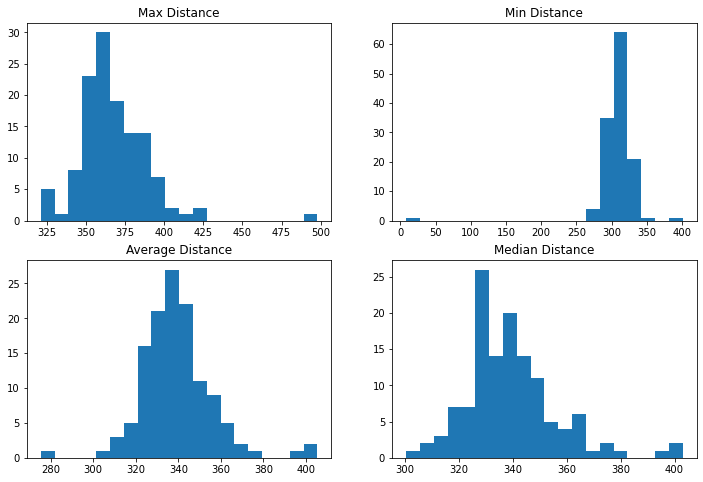

In [28]:
# Histogram of the max distance, min distance, average distance, and median distance

fig, ax = plt.subplots(2, 2, figsize=(12, 8))

ax[0, 0].hist(df_cleaned['max_distance'], bins=20)

ax[0, 1].hist(df_cleaned['min_distance'], bins=20)

ax[1, 0].hist(df_cleaned['avg_distance'], bins=20)

ax[1, 1].hist(df_cleaned['median_distance'], bins=20)

ax[0, 0].set_title('Max Distance')
ax[0, 1].set_title('Min Distance')

ax[1, 0].set_title('Average Distance')
ax[1, 1].set_title('Median Distance')

plt.show()


In [29]:
## Compile a list of fields that are outliers

outlier_fields = df_cleaned[(df_cleaned['max_distance'] > 400) | (df_cleaned['min_distance'] < 200) | (df_cleaned['avg_distance'] > 400) | (df_cleaned['median_distance'] > 400)]

len(outlier_fields)

print(outlier_fields['park_name'].values)



['Wayne State Univ - college' 'Lowell High School - high school' 'Caro HS'
 'Laura F. Osborn HS' 'Ann Arbor Greenhills HS'
 'Historic Hamtramck Stadium - muni']


In [30]:
# Create list of the top and bottom ten from each category

top_ten_max = df_cleaned.sort_values(by='max_distance', ascending=False).head(10)
top_ten_min = df_cleaned.sort_values(by='min_distance', ascending=True).head(10)

top_ten_avg = df_cleaned.sort_values(by='avg_distance', ascending=False).head(10)
top_ten_median = df_cleaned.sort_values(by='median_distance', ascending=False).head(10)

top_ten_field_area = df_cleaned.sort_values(by='field_area_sqft', ascending=False).head(10)

top_ten_foul_area = df_cleaned.sort_values(by='foul_area_sqft', ascending=False).head(10)

top_ten_fop_area = df_cleaned.sort_values(by='fop_area_sqft', ascending=False).head(10)

top_ten_ratio = df_cleaned.sort_values(by='fair_to_foul', ascending=False).head(10)

bottom_ten_ratio = df_cleaned.sort_values(by='fair_to_foul', ascending=True).head(10)

bottom_ten_max = df_cleaned.sort_values(by='max_distance', ascending=True).head(10)
bottom_ten_min = df_cleaned.sort_values(by='min_distance', ascending=False).head(10)
bottom_ten_avg = df_cleaned.sort_values(by='avg_distance', ascending=True).head(10)
bottom_ten_median = df_cleaned.sort_values(by='median_distance', ascending=True).head(10)


### Create and display a dataframe with columns for the top and bottom ten fields for each category

top_bottom_df = pd.DataFrame()

top_bottom_df['top_ten_max'] = top_ten_max['park_name'].values
top_bottom_df['top_ten_min'] = top_ten_min['park_name'].values
top_bottom_df['top_ten_avg'] = top_ten_avg['park_name'].values

top_bottom_df['top_ten_median'] = top_ten_median['park_name'].values
top_bottom_df['top_ten_field_area'] = top_ten_field_area['park_name'].values
top_bottom_df['top_ten_foul_area'] = top_ten_foul_area['park_name'].values
top_bottom_df['top_ten_fop_area'] = top_ten_fop_area['park_name'].values
top_bottom_df['top_ten_ratio'] = top_ten_ratio['park_name'].values

top_bottom_df['bottom_ten_ratio'] = bottom_ten_ratio['park_name'].values
top_bottom_df['bottom_ten_max'] = bottom_ten_max['park_name'].values
top_bottom_df['bottom_ten_min'] = bottom_ten_min['park_name'].values
top_bottom_df['bottom_ten_avg'] = bottom_ten_avg['park_name'].values
top_bottom_df['bottom_ten_median'] = bottom_ten_median['park_name'].values


top_bottom_df.head(10)




,top_ten_max,top_ten_min,top_ten_avg,top_ten_median,top_ten_field_area,top_ten_foul_area,top_ten_fop_area,top_ten_ratio,bottom_ten_ratio,bottom_ten_max,bottom_ten_min,bottom_ten_avg,bottom_ten_median
0,Historic Hamtramck Stadium - muni,Ann Arbor Greenhills HS,Historic Hamtramck Stadium - muni,Laura F. Osborn HS,Lowell High School - high school,Lowell High School - high school,Laura F. Osborn HS,Zeeland West HS,Historic Hamtramck Stadium - Replot - muni - w...,Central Lake HS - high_school,Laura F. Osborn HS,Ann Arbor Greenhills HS,Hart HS
1,Ann Arbor Greenhills HS,Colon High School - high school,Laura F. Osborn HS,Lowell High School - high school,Historic Hamtramck Stadium - muni,Historic Hamtramck Stadium - muni,Lowell High School - high school,U of M - college,Ann Arbor Greenhills HS,Zeeland West HS,Lowell High School - high school,Kingston HS,Kingston HS
2,Wayne State Univ - college,Kingston HS,Lowell High School - high school,Historic Hamtramck Stadium - muni,Laura F. Osborn HS,Historic Hamtramck Stadium - Replot - muni - w...,Historic Hamtramck Stadium - muni,Romeo high School - high school,Gaylord St Mary High School - high school,Martin HS,Historic Hamtramck Stadium - muni,Hart HS,Ann Arbor Greenhills HS
3,Lowell High School - high school,Alcona HS,Kalamazoo College - college,Kalamazoo College - college,Sagniaw Valley State - college,St Joseph HS,Kalamazoo College - college,Sanborn Park - Port Huron - muni,Saline High School - Field 1 - high school,Ecorse High School,Flushing HS,Central Lake HS - high_school,Central Lake HS - high_school
4,Caro HS,Owosso HS,CMU - college,CMU - college,Gaylord High School - high school,Saline High School - Field 1 - high school,CMU - college,Royal Oak High School - high school,St Joseph HS,Peck HS,Sagniaw Valley State - college,Martin HS,Harbor Springs High School
5,Laura F. Osborn HS,Frankfort-Elberta Area HS,Sagniaw Valley State - college,Sagniaw Valley State - college,Kalamazoo College - college,Gaylord High School - high school,Sagniaw Valley State - college,Sterling Heights - Parkway Christian High School,New Buffalo HS,Kingston HS,Sanborn Park - Port Huron - muni,Owosso HS,Negaunee high School - Irontown Field - high s...
6,Marquette HS - Hurley Field,Vicksburg HS,Flushing HS,Grass Lake HS - high school,Middleville Thornapple Kellogg HS,Gaylord St Mary High School - high school,Flushing HS,Fowlerville HS,Adrian HS,Owosso HS,Clare High School,Harbor Springs High School,Martin HS
7,CMU - college,Gross Pointe North High School,Newaygo High School - high school,Newaygo High School - high school,White Lake Lakeland HS,Ann Arbor Greenhills HS,Bay City john Glen HS,Clare High School,Galesburg-Augusta HS,Negaunee high School - Irontown Field - high s...,CMU - college,Negaunee high School - Irontown Field - high s...,Owosso HS
8,Kalamazoo College - college,Algonac High School,Gaylord High School - high school,U of M - college,Historic Hamtramck Stadium - Replot - muni - w...,Sagniaw Valley State - college,Grass Lake HS - high school,CMU - college,Mendon High School,Escanaba HS,White Lake Lakeland HS,Ecorse High School,Gross Pointe North High School
9,Flushing HS,Grandville HS - Field 2 - JV - high school,Bay City john Glen HS,Flushing HS,St Joseph HS,New Buffalo HS,Gaylord High School - high school,Burton Bentley HS,Escanaba HS,Harbor Springs High School,Grand Rapids Forest Hills Northern HS,Peck HS,Peck HS


In [31]:
import json

### Load prelim JSON as data

with open('data/mhsaa_step1.json') as f:

    data = json.load(f)



In [32]:
### NEW WITH AUTO SCALING

def calculate_max_y(data, num_bins=36, level_filter=None):
    count_by_orientation = process_data(data, level_filter)
    
    # Compute the histogram
    bin_counts = np.zeros(num_bins)
    
    for orientation, count in count_by_orientation.items():
        idx = int(orientation / (360 / num_bins))
        if idx == num_bins:
            idx = 0
        bin_counts[idx] += count
    
    return max(bin_counts)


def create_polar_chart(data, num_bins=36, level_filter=None, y_min=-20, background_color='#2b2b2b', color_map=plt.cm.viridis, bar_alpha=0.8):
    count_by_orientation = process_data(data, level_filter)
    
    # Compute the histogram
    bin_edges = np.linspace(0.0, 2 * np.pi, num_bins + 1)
    bin_counts = np.zeros(num_bins)
    
    for orientation, count in count_by_orientation.items():
        idx = int(orientation / (360 / num_bins))
        if idx == num_bins:
            idx = 0
        bin_counts[idx] += count
    
    bin_width = 2 * np.pi / num_bins

    # Set plot size
    plt.figure(figsize=(10, 10))

    ax = plt.subplot(111, projection='polar')
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi / 2)

    ax.set_facecolor('#808080')
    # ax.set_yscale('log')

    # Set dark background
    ax.set_facecolor(background_color)
    plt.gca().set_rlabel_position(22.5)
    y_max = calculate_max_y(data, num_bins=num_bins, level_filter=level_filter) + 5
    ax.set_ylim(y_min, y_max)  # Adjust based on max count

    # Add bars for negative values
    zero_height_bars = ax.bar(bin_edges[:-1], np.abs(ax.get_ylim()[0]), width=bin_width, bottom=0.0, color='k', alpha=0.3)

    bars = ax.bar(bin_edges[:-1], bin_counts, width=bin_width, bottom=0)
    
    # Use custom colors and opacity
    for r, bar in zip(bin_counts, bars):
        bar.set_facecolor(color_map(r / max(bin_counts)))
        bar.set_alpha(bar_alpha)

    plt.show()


In [33]:
##### CALL AUTO ADJUSTING CHART #####


## NEW PERAMS


# Call your function
create_polar_chart(
    data, 
    num_bins=30, 
    # level_filter="level1", 
    y_min=0, 
    background_color='#2b2b2b', 
    color_map=plt.cm.viridis, 
    bar_alpha=0.8
)


NameError: name 'process_data' is not defined

In [ ]:
## NEW CHAT GPT CODE

def create_polar_chart(data, num_bins=36, level_filter=None, y_min=-20, y_max=130, background_color='#2b2b2b', color_map=plt.cm.viridis, bar_alpha=0.8):
    count_by_orientation = process_data(data, level_filter)
    
    # Compute the histogram
    bin_edges = np.linspace(0.0, 2 * np.pi, num_bins + 1)
    bin_counts = np.zeros(num_bins)
    
    for orientation, count in count_by_orientation.items():
        idx = int(orientation / (360 / num_bins))
        if idx == num_bins:
            idx = 0
        bin_counts[idx] += count
    
    bin_width = 2 * np.pi / num_bins

    # Set plot size
    plt.figure(figsize=(10, 10))

    ax = plt.subplot(111, projection='polar')
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi / 2)

    ax.set_facecolor('#808080')
    # ax.set_yscale('log')

    # Set dark background
    ax.set_facecolor(background_color)
    plt.gca().set_rlabel_position(22.5)
    ax.set_ylim(y_min, y_max)  # Adjust based on max count

    # Add bars for negative values
    zero_height_bars = ax.bar(bin_edges[:-1], np.abs(ax.get_ylim()[0]), width=bin_width, bottom=0.0, color='k', alpha=0.3)

    bars = ax.bar(bin_edges[:-1], bin_counts, width=bin_width, bottom=0)
    
    # Use custom colors and opacity
    for r, bar in zip(bin_counts, bars):
        bar.set_facecolor(color_map(r / max(bin_counts)))
        bar.set_alpha(bar_alpha)

    plt.show()


In [ ]:
### Create a polar chart showing the direction of all the tournment fields


import numpy as np
import matplotlib.pyplot as plt

# create a function to process the data, counting the orientations and filtering by level.

from collections import defaultdict

def process_data(data, level_filter=None):
    count_by_orientation = defaultdict(int)
    
    for record in data:
        if level_filter is None or record['level'] == level_filter:
            orientation = round(record['field_orientation'])
            count_by_orientation[orientation] += 1

    return count_by_orientation

def create_polar_chart(data, num_bins=36, level_filter=None):
    count_by_orientation = process_data(data, level_filter)
    
    # Compute the histogram
    bin_edges = np.linspace(0.0, 2 * np.pi, num_bins + 1)
    bin_counts = np.zeros(num_bins)
    
    for orientation, count in count_by_orientation.items():
        idx = int(orientation / (360 / num_bins))
        if idx == num_bins:
            idx = 0
        bin_counts[idx] += count
    
    bin_width = 2 * np.pi / num_bins

    # Set plot size
    plt.figure(figsize=(10, 10))

    ax = plt.subplot(111, projection='polar')
    ax.set_theta_direction(-1)
    ax.set_theta_offset(np.pi / 2)

    ax.set_facecolor('#808080')
    ###
    # ax.set_yscale('log')

    
    # # Set dark background
    ax.set_facecolor('#2b2b2b')
    plt.gca().set_rlabel_position(22.5)
    ax.set_ylim(-20, 130)  # Adjust based on max count

    # Add bars for negative values
    zero_height_bars = ax.bar(bin_edges[:-1], np.abs(ax.get_ylim()[0]), width=bin_width, bottom=0.0, color='k', alpha=0.3)

    bars = ax.bar(bin_edges[:-1], bin_counts, width=bin_width, bottom=0)
    
    # Use custom colors and opacity
    for r, bar in zip(bin_counts, bars):
        bar.set_facecolor(plt.cm.viridis(r / max(bin_counts)))
        # bar.set_facecolor(plt.cm.plasma(r / max(bin_counts)))
        bar.set_alpha(0.8)

    plt.show()

In [ ]:
create_polar_chart(data, num_bins=50, level_filter=None)